# 邏輯迴歸（Logistic Regression）

二元分類交叉熵損失（Binary Cross-Entropy Loss）：

$$\mathcal L(\pmb w) = -\frac{1}{m}\sum_{i=1}^{m}\bigl (y^i \log(f_{\pmb w}({\pmb x}^i)) +(1-y^i) \log(1-f_{\pmb w}({\pmb x}^i))\bigr )$$

將樣本表示為列向量（Row vector）形式，梯度 $\nabla_{\pmb w} { L(\pmb w)}$ 同樣表示為列向量形式，可表示為：

$$\nabla_{\pmb w} { L(\pmb w)} = \frac{1}{m} {\bigl( \pmb f- \pmb y \bigr )}^T X =  \frac{1}{m} {\bigl( \sigma(\pmb X \pmb w)- \pmb  y \bigr )}^T X$$

將樣本表示為行向量（Column vector）形式，將梯度表示為列向量形式，則：

$$\begin{aligned} \nabla_{\pmb w} { L(\pmb w)} &= \begin{bmatrix}
\frac {\partial L(\pmb w)} {\partial {w_0} }  &
\frac {\partial L(\pmb w)} {\partial {w_1} } &
\frac {\partial L(\pmb w)} {\partial {w_2} } &
\cdots &
\frac {\partial L(\pmb w)} {\partial {w_K} } &
\end{bmatrix}= \frac{1}{m} {\bigl (\pmb f-\pmb y\bigr )} {\pmb X}^T \end{aligned}$$

為邏輯迴歸的損失函數添加正規化（Regularization），即 $L(\pmb w)$ 為：

$$L(\pmb w) = -\frac{1}{m}\sum_{i=1}^{m}(y^i \log(f_{\pmb w}({\pmb x}^i)) +(1-y^i) \log(1-f_{\pmb w}({\pmb x}^i))) + \lambda \|{\pmb w}\|^2$$

相應地，$L(\pmb w)$ 對於 $\pmb w$ 的梯度即為：

$$ \nabla_{\pmb w} { L(\pmb w)}  = \frac{1}{m}\sum_{i=1}^{m} (f_{\pmb w}({\pmb x}^i)-y^i){\pmb x}^i+2\lambda \pmb w$$

如果每個樣本 $\pmb x$ 為列向量形式，多個樣本的 $\pmb f, \pmb y$ 以及模型參數 $\pmb w$ 皆為行向量形式，則可以寫成如下的向量化（Vectorized）形式：

$$\nabla_{\pmb w} { L(\pmb w)} = \frac{1}{m} {\bigl( \pmb f- \pmb y \bigr )}^T X + 2\lambda \pmb w =  \frac{1}{m} {\bigl( \sigma(\pmb X \pmb w)- \pmb  y \bigr )}^T X + 2\lambda \pmb w$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 設定隨機編號，確保每次執行生成的隨機資料都相同，方便實驗復現
np.random.seed(0)

n_pts = 100 # 每個類別的樣本點數量
D = 2       # 資料的維度（特徵數量）

# 生成第一組資料 Xa (類別 0)：
# 第一個特徵服從平均值 10、標準差 2 的常態分配
# 第二個特徵服從平均值 12、標準差 2 的常態分配
Xa = np.array([np.random.normal(10, 2, n_pts),
               np.random.normal(12, 2, n_pts)])

# 生成第二組資料 Xb (類別 1)：
# 第一個特徵服從平均值 5、標準差 2 的常態分配
# 第二個特徵服從平均值 6、標準差 2 的常態分配
Xb = np.array([np.random.normal(5, 2, n_pts),
               np.random.normal(6, 2, n_pts)])

# 將兩組資料合併。axis=1 代表水平合併，隨後轉置 (.T) 使其符合 (樣本數, 特徵數) 的格式
X = np.append(Xa, Xb, axis=1).T

# 建立標籤資料 (y)：前 100 個為 0，後 100 個為 1，並轉置為行向量
y = (np.append(np.zeros(n_pts), np.ones(n_pts))).T

# 每隔 50 筆資料印出一次，觀察 X 特徵矩陣與 y 標籤向量
print(X[::50])
print(y[::50])

[[13.52810469 15.76630139]
 [ 8.20906688 11.86351679]
 [ 4.26163632  3.3869463 ]
 [ 6.04212975  4.47171215]]
[0. 0. 1. 1.]


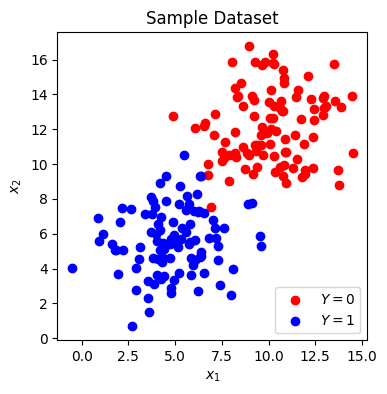

In [ ]:
# 建立一個畫布 (fig) 與子圖物件 (ax)，並設定圖表尺寸為 4x4 英吋
fig, ax = plt.subplots(figsize=(4,4))

# 繪製類別 Y = 0 的散佈圖：取前 n_pts 筆資料
ax.scatter(X[:n_pts,0], X[:n_pts,1], color='r', label='$Y = 0$')

# 繪製類別 Y = 1 的散佈圖：取 n_pts 之後的所有資料
ax.scatter(X[n_pts:,0], X[n_pts:,1], color='b', label='$Y = 1$')

# 設定圖表標題
ax.set_title('Sample Dataset')

# 設定 x 軸與 y 軸的標籤（使用 LaTeX 語法顯示數學符號）
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# 顯示圖例，並將位置設定在右下角 (location 4)
ax.legend(loc=4);

In [ ]:
def sigmoid(z):
    # Sigmoid 激活函數，將實數映射至 (0, 1) 之間
    return 1 / (1 + np.exp(-z))

def gradient_descent_logistic_reg(X, y, lambda_, alpha, num_iters, gamma=0.8, epsilon=1e-8):
    # w_history: 紀錄迭代過程中的參數
    w_history = []
    # 在特徵矩陣左側添加一列全為 1 的向量，代表截距項 (bias)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    num_features = X.shape[1]
    v = np.zeros_like(num_features) # 初始化動量項 (velocity)
    w = np.zeros(num_features)      # 初始化權重參數 (w)

    for n in range(num_iters):
        # 求假設函數的預測值，即 f(x) = sigmoid(Xw)
        predictions = sigmoid(X @ w)

        # 預測值與真實值之間的誤差
        errors = predictions - y

        # 計算梯度：這裡使用向量化運算，結果為行向量
        gradient = errors.transpose() @ X / len(y)

        # 加入 L2 正規化項的梯度
        gradient += 2 * lambda_ * w

        # 檢查梯度是否已經足夠小（收斂條件）
        if np.max(np.abs(gradient)) < epsilon:
            print("梯度已足夠小，停止迭代！")
            print("總迭代次數為：", n)
            break

        # 更新模型參數：使用帶有動量的更新公式 (Momentum Update)
        v = gamma * v + alpha * gradient
        w = w - v

        w_history.append(w)

    return w_history  # 回傳優化後的參數歷史紀錄

In [ ]:
def loss_logistic(w, X, y, reg=0.):
    """
    計算邏輯迴歸的二元交叉熵損失值 (Binary Cross Entropy Loss)
    """
    # 計算預測機率 f：將偏置項 (bias) w[0] 與權重項 w[1:] 分開計算
    f = sigmoid(X @ w[1:] + w[0])

    # 計算二元交叉熵損失
    # 使用 np.mean 計算所有樣本的平均損失
    loss = -np.mean((np.log(f).T * y + np.log(1 - f).T * (1 - y)))

    # 加入 L2 正規化項（懲罰項），控制模型複雜度以防止過擬合
    loss += reg * (np.sum(np.square(w)))

    return loss

def loss_history_logistic(w_history, X, y, reg=0.):
    """
    計算整個訓練過程中，每一代 (iteration) 的損失值歷史紀錄
    """
    loss_history = []
    for w in w_history:
        # 呼叫 loss_logistic 計算當前參數 w 的損失
        loss_history.append(loss_logistic(w, X, y, reg))
    return loss_history

最終權重 w: [11.3920102  -0.55377808 -0.83931251]
損失值變化趨勢: [np.float64(0.6577262444936194), np.float64(0.2267463703642394), np.float64(0.15646446608041154), np.float64(0.12698570286225017), np.float64(0.11034864425987873), np.float64(0.09949355960364478), np.float64(0.09177469381378581), np.float64(0.08596435646154407), np.float64(0.08141010065377202), np.float64(0.07773089221384288)]


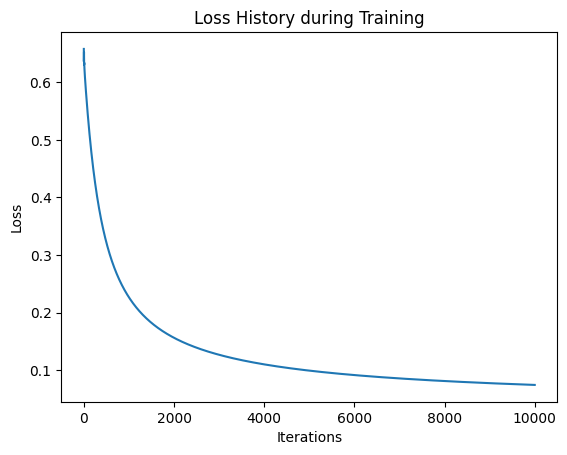

In [ ]:
# 設定超參數
reg = 0.0          # 正規化係數 (lambda)，此處設為 0 代表不使用正規化
alpha = 0.01       # 學習率 (Learning Rate)
iterations = 10000 # 迭代次數

# 執行邏輯迴歸梯度下降，取得參數更新歷史紀錄
w_history = gradient_descent_logistic_reg(X, y, reg, alpha, iterations)

# 取得最後一次迭代後的權重 w (即最終模型參數)
w = w_history[-1]
print("最終權重 w:", w)

# 計算整個訓練過程的損失函數歷史紀錄
loss_history = loss_history_logistic(w_history, X, y, reg)

# 以間隔方式（約取 10 個點）印出損失值，觀察下降趨勢
print("損失值變化趨勢:", loss_history[:-1:len(loss_history)//10])

# 繪製損失函數隨迭代次數變化的曲線圖
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss History during Training")
plt.show()

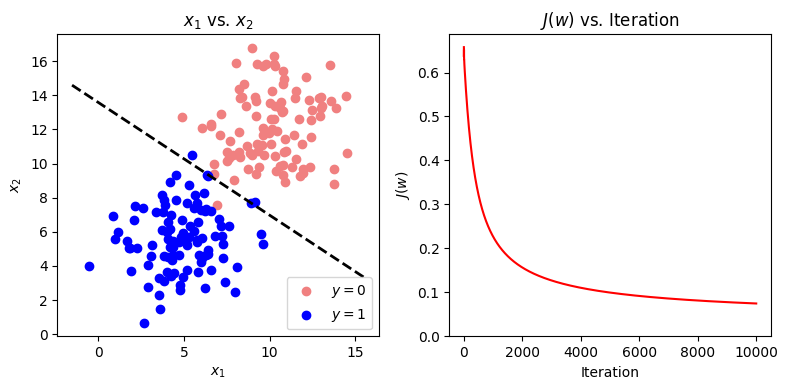

In [ ]:
# 建立一個 1 列 2 欄的子圖佈局
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# 計算決策邊界的座標點
# 邏輯迴歸的決策邊界發生在 w0 + w1*x1 + w2*x2 = 0 之處
# 移項後得到 x2 = -w0/w2 + x1*(-w1/w2)
x1 = np.array([X[:,0].min()-1, X[:,0].max()+1])
x2 = - w.item(0) / w.item(2) + x1 * (- w.item(1) / w.item(2))

# 在左圖 (ax[0]) 繪製決策邊界：黑色虛線 (--k)
ax[0].plot(x1, x2, color='k', ls='--', lw=2)

# 繪製類別 0 與類別 1 的資料點
ax[0].scatter(X[:int(n_pts),0], X[:int(n_pts),1], color='lightcoral', label='$y = 0$')
ax[0].scatter(X[int(n_pts):,0], X[int(n_pts):,1], color='blue', label='$y = 1$')
ax[0].set_title('$x_1$ vs. $x_2$')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].legend(loc=4)

# 在右圖 (ax[1]) 繪製損失函數隨迭代次數變化的曲線
ax[1].plot(loss_history, color='r')
# 設定 y 軸從 0 開始，方便觀察損失下降的比例
ax[1].set_ylim(0, ax[1].get_ylim()[1])
ax[1].set_title(r'$J(w)$ vs. Iteration')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'$J(w)$')

# 自動調整子圖間距，避免文字重疊
fig.tight_layout()

In [ ]:
# 在特徵矩陣左側添加一列全為 1 的向量，以匹配包含截距項的權重 w
X_1 = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

# 將 Sigmoid 輸出的機率值轉換為類別預測
# 若機率 >= 0.5 則預測為類別 1，否則為類別 0
y_predictions = sigmoid(X_1 @ w) >= 0.5

# 計算預測準確度
# np.dot(y, y_predictions): 計算標籤為 1 且預測正確的數量
# np.dot(1 - y, 1 - y_predictions): 計算標籤為 0 且預測正確的數量
accuracy = float((np.dot(y, y_predictions) + np.dot(1 - y, 1 - y_predictions)) / float(y.size) * 100)

print('預測的準確度是: %d%%' % accuracy)

預測的準確度是: 98%


# 鳶尾花的範例

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
               Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count  150.000000     150.000000    150.000000     150.000000    150.000000
mean    75.500000       5.843333      3.054000       3.758667      1.198667
std     43.445368       0.828066      0.433594       1.764420      0.763161
min      1.000000       4.300000      2.000000       1.000000      0.100000
25%     38.250000       5.100000      2.800000       1.600000      0.300000
50%     75.500000       5.80000

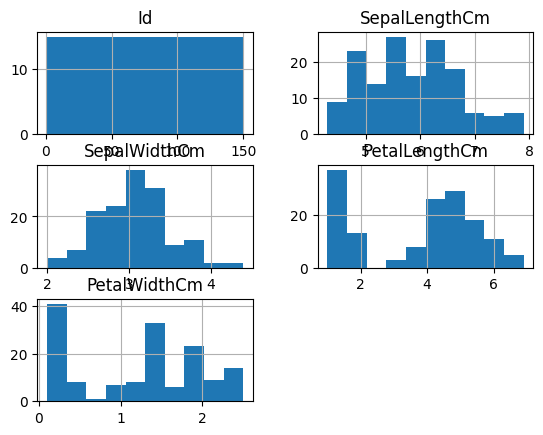

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/Iris.csv')
print(data.head())
print(data.Species.unique())
print(data.describe())
print(data.info())

data.hist()
plt.show()

In [1]:
X = data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
print(X[:3])

y = (data['Species'] == 'Iris-setosa').values.astype(int)
print(y[:3])
print(y)

y2 = data.target
classes = np.unique(y2) # [0, 1, 2]

NameError: name 'data' is not defined

最終權重 w: [ 0.45737679  0.7240606   2.48656694 -3.88383895 -1.78704727]
損失值變化趨勢: [np.float64(0.656430089279477), np.float64(0.013552260994369672), np.float64(0.007288937101698596), np.float64(0.005069978207507636), np.float64(0.00391848944058157), np.float64(0.003208601038709519), np.float64(0.0027250809679995936), np.float64(0.0023735157492462723), np.float64(0.0021058062798299153), np.float64(0.0018948069243006846)]


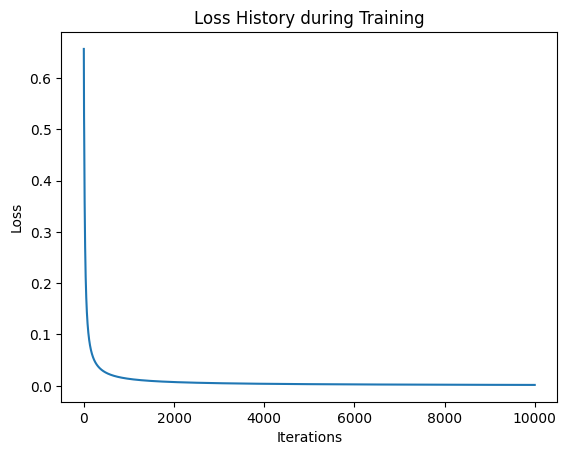

In [ ]:
# 設定超參數
reg = 0.0          # 正規化係數 (lambda)，此處設為 0 代表不使用正規化
alpha = 0.01       # 學習率 (Learning Rate)
iterations = 10000 # 迭代次數

# 執行邏輯迴歸梯度下降，取得參數更新歷史紀錄
w_history = gradient_descent_logistic_reg(X, y, reg, alpha, iterations)

# 取得最後一次迭代後的權重 w (即最終模型參數)
w = w_history[-1]
print("最終權重 w:", w)

# 計算整個訓練過程的損失函數歷史紀錄
loss_history = loss_history_logistic(w_history, X, y, reg)

# 以間隔方式（約取 10 個點）印出損失值，觀察下降趨勢
print("損失值變化趨勢:", loss_history[:-1:len(loss_history)//10])

# 繪製損失函數隨迭代次數變化的曲線圖
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss History during Training")
plt.show()

In [ ]:
test_x = [6.6, 3.5, 1.0, 0.3]
f = sigmoid(test_x @ w[1:] + w[0])
print(f)

0.9998249624850309


In [ ]:
# 在特徵矩陣左側添加一列全為 1 的向量，以匹配包含截距項的權重 w
X_1 = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

# 將 Sigmoid 輸出的機率值轉換為類別預測
# 若機率 >= 0.5 則預測為類別 1，否則為類別 0
y_predictions = sigmoid(X_1 @ w) >= 0.5

# 計算預測準確度
# np.dot(y, y_predictions): 計算標籤為 1 且預測正確的數量
# np.dot(1 - y, 1 - y_predictions): 計算標籤為 0 且預測正確的數量
accuracy = float((np.dot(y, y_predictions) + np.dot(1 - y, 1 - y_predictions)) / float(y.size) * 100)

print('預測的準確度是: %d%%' % accuracy)

預測的準確度是: 100%
